# **Kepler Exoplanet Classification Using Neural Networks**

Having previously explored how to classify Kepler exoplanet candidates using a decision tree, we now turn to a neural network (NN) approach. This notebook demonstrates how to prepare the data, define and train a neural network, and evaluate its performance. We will also compare the results with the Random Forest from Question 1 to see how the two approaches differ.


## **Libraries**

We begin by importing the Python libraries required to build, train, and evaluate a neural network classifier using PyTorch. We will use:

* **PyTorch (`torch`)** to define the neural network architecture, specify the loss function, and perform optimisation during training.
* **scikit-learn** for splitting the dataset into training and test sets, standardising input features so they're on comparable scales, evaluating model performance.
* **pandas** for loading, inspecting, and manipulating the dataset.
* **matplotlib** and **seaborn** for visualising model performance, including confusion matrices.

Using `scikit-learn` for preprocessing and evaluation allows us to make a fair comparison with the traditional machine learning model explored in Question 1, while `PyTorch` provides the flexibility needed to implement a neural network from first principles.

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation and visualisation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## **Loading the Dataset** 

We begin by loading the Kepler exoplanet dataset using `pandas`. Each row in the dataset corresponds to a single Kepler Object of Interest (KOI), with columns describing both stellar properties and candidate planetary characteristics.

Most of the dataset exploration was already covered in Question 1, to avoid unnecessary reptition, we only briefly inspect the dataset here to confirm it loaded correctly and is in the expected format before proceeding to preprocessing and model training.


In [3]:
# Load the dataset
raw_data = pd.read_csv("data/cumulative.csv")

# Set pandas display options to make debugging easier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the first few rows of the dataset
raw_data.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


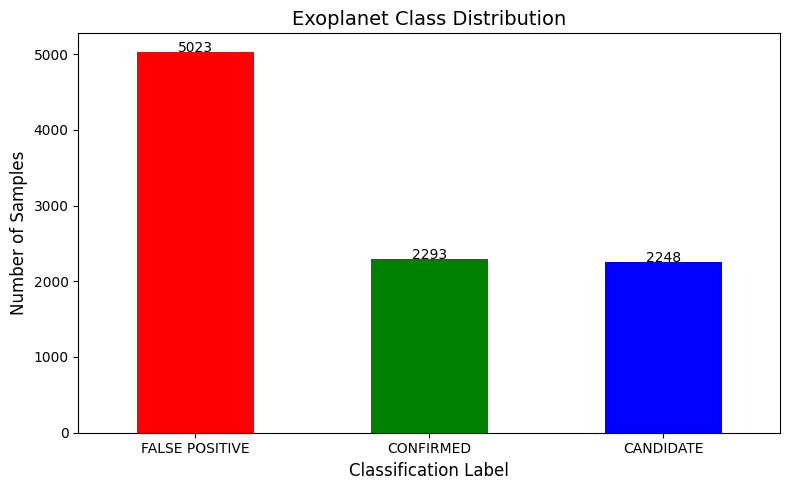

In [4]:
# Count the number of samples in each class
class_counts = raw_data['koi_disposition'].value_counts()

# Define a colour for each class
colors = ['red', 'green', 'blue']

# Plot the class distribution
plt.figure(figsize = (8,5))
ax = class_counts.plot(kind = 'bar', color = colors)

# Add labels and title
plt.xlabel("Classification Label", fontsize = 12)
plt.ylabel("Number of Samples", fontsize = 12)
plt.title("Exoplanet Class Distribution", fontsize = 14)
plt.xticks(rotation = 0)
plt.tight_layout()

# Annotate bars with counts
for n, count in enumerate(class_counts):
    ax.text(n, count +5, str(count), ha = 'center', fontsize = 10)

plt.show()

## **Selecting Features and Target**

Next, we define which columns from the dataset will be used as input features for the neural network, as well as the target variable the model will learn to predict.

We select features that describe:

* **Stellar parameters**: properties of the host star, which can influence how transits are observed and interprted.
* **Planetary candidate parameters**: properties of the transit itself, which are directly related to whether a detected signal is likely to correspond to a real exoplanet.

These features were explored in detail in Question 1. Here, we reuse them to ensure consistency and to allow a fair comparison between traditional machine learning models and a neural network approach.

In [5]:
# Features to use for classification
features = [
    # STELLAR PARAMETERS
    "koi_steff",      # Stellar effective temperature (K)
    "koi_slogg",      # Stellar surface gravity (log10(cm/s^2))
    "koi_srad",       # Stellar radius (Solar radii)
    
    # PLANETARY CANDIDATE PARAMETERS
    "koi_period",     # Orbital period (days)
    "koi_duration",   # Transit duration (hours)
    "koi_depth",      # Transit depth (ppm)
    "koi_prad",       # Planetary radius (Earth radii)
]

# Target variable
target = 'koi_disposition'


The target variable, `koi_disposition`, labels each Kepler Object of Interest as:

* `CONFIRMED` a validated exoplanet,

* `CANDIDATE` a likely planet requiring further confirmation,

* `FALSE POSITIVE` a signal caused by non-planetary astrophysical effects or noise.

The goal of the neural network is to learn a mapping from the selected physical features to these classification outcomes.

## **Handling Missing Values**

Machine learning models, including neural networks, cannot operate directly on missing values (represented as `NaN` in pandas). These missing entries typically arise from incomplete observations or measurements that could not be reliably determined.

Before training the model, we therefore need to decide how to handle any missing data in the selected features or target variable.

In this notebook, we remove rows containing missing values in either the input features or the target variable. This mirrors the preprocessing strategy used in Question 1, ensuring that comparisons between the Decision Tree and Neural Network models remain fair and consistent.

While alternative approaches such as mean or median imputation are often used, only a small fraction of the dataset contains missing values. As a result, dropping these rows is unlikely to significantly affect the overall dataset size or the model’s performance.

In [6]:
# Check for missing values in each column
missing_values = raw_data[features + [target]].isna().sum()
print("Missing values in each column:\n", missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(raw_data)) * 100
print("\nPercentage of missing values in each column:\n", missing_percentage)

# Drop rows with missing values in features or target
cleaned_data = raw_data[features + [target]].dropna()
print(f"Rows after dropping NaNs:", len(cleaned_data))

Missing values in each column:
 koi_steff          363
koi_slogg          363
koi_srad           363
koi_period           0
koi_duration         0
koi_depth          363
koi_prad           363
koi_disposition      0
dtype: int64

Percentage of missing values in each column:
 koi_steff          3.795483
koi_slogg          3.795483
koi_srad           3.795483
koi_period         0.000000
koi_duration       0.000000
koi_depth          3.795483
koi_prad           3.795483
koi_disposition    0.000000
dtype: float64
Rows after dropping NaNs: 9201


## **Encoding the Target and Preparing Features**

Neural networks operate exclusively on numerical data, so both the input features and the target labels must be represented as numbers before training.

**Encoding the target variable**

The target column, `koi_disposition`, is stored as string labels. We therefore map each class to an integer label:

* `CANDIDATE`: 0  
* `CONFIRMED`: 1  
* `FALSE POSITIVE`: 2  

After encoding the target, we separate the dataset into features (`X`) and labels (`y`).  

We then standardise the features so that each has a mean of 0 and standard deviation of 1. Standardisation helps neural networks train more efficiently.  

Next, we split the dataset into training (80%) and test (20%) sets. We use stratification to ensure that the class proportions are preserved in both sets.  

Finally, we convert the NumPy arrays into PyTorch tensors and wrap them in `TensorDataset` objects. Using `DataLoaders` allows the neural network to process data efficiently in batches during training.  

This workflow ensures our data is fully prepared for training a neural network, while remaining consistent with the preprocessing applied in `Question 1`.

In [7]:
# Map classes to integers
target_mapping = {
    'CANDIDATE': 0,
    'CONFIRMED': 1,
    'FALSE POSITIVE': 2
}

# Apply mapping to target column
cleaned_data[target] = cleaned_data[target].replace(target_mapping)

/tmp/ipykernel_932/2186339268.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data[target] = cleaned_data[target].replace(target_mapping)


After encoding, we remove any remaining rows where the target label is still missing. This ensures that every training example has a valid class label.

In [9]:
# Drop any rows where target is still missing
cleaned_data = cleaned_data.dropna(subset=[target])
print("Rows after dropping remaining NaNs:", len(cleaned_data))

Rows after dropping remaining NaNs: 9201


**Separating features and labels**

We now separate the dataset into:

* **Features (X)** the physical input parameters used by the model.
* **Labels (y)** the encoded class values the model aims to predict.

In [11]:
# Separate features (X) and target labels (y)
X = cleaned_data[features].values # Features as NumPy array
y = cleaned_data[target].values # Target labels as NumPy array

**Feature standardisation**

Neural networks are sensitive to the scale of input features. If some features are much larger than others, they can dominate the learning process and slow convergence.

To avoid this, we standardise all features so that each has:

* a mean of 0
* a standard deviation of 1

This generally leads to faster and more stable training.

In [12]:
# Scale features (neural networks trains more efficiently with scaled input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train/test split**

We split the dataset into training (80%) and test (20%) sets. The training set is used to learn the model parameters, while the test set is reserved for evaluating performance on unseen data.

We use stratification to preserve the relative proportions of each class in both sets, which is particularly important when class imbalance may be present.

In [13]:
# Split into training and test sets
# Stratify ensures class proportions are preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

**Converting data to PyTorch tensors**

PyTorch models operate on tensor objects, so we convert the NumPy arrays into tensors with appropriate data types:

* Feature tensors use `float32`

* Target tensors use `long`, as required for classification loss functions

In [14]:
# Convert NumPy arrays to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

**Creating datasets and data loaders**

We wrap the tensors in `TensorDataset` objects, which pair each feature vector with its corresponding label.

We then use `DataLoader` objects to:
* Feed data to the neural network in mini-batches
* Shuffle the training data each epoch to improve generalisation

In [16]:
# Create PyTorch TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create PyTorch DataLoaders to efficiently feed data to neural network
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

As a final sanity check, we print the number of samples in each split.

In [17]:
# Print dataset sizes to verify split
print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))

Training samples: 7360
Testing samples: 1841


## **Defining the Neural Network**

Next, we create a neural network to classify Kepler exoplanet candidates.  

Here's how it works:

* **Input layer**: The network takes 7 features describing the star and candidate planet.  
* **Hidden layer**: A fully connected layer with 64 neurons, followed by a ReLU activation function..
* **Dropout**: During training, we randomly “turn off” 20% of neurons. This helps prevent overfitting, making the model generalise better to new data.  
* **Output layer**: 3 neurons, one for each class (`CANDIDATE`, `CONFIRMED`, `FALSE POSITIVE`).  

The output layer produces raw scores (logits), which will later be converted into class probabilities by the loss function.

We use the **ReLU (Rectified Linear Unit)** activation function in the hidden layer because it is computationally efficient and performs well in practice for many classification problems.

**Implementing the network in PyTorch**

The network is implemented in PyTorch by creating a class that subclasses `nn.Module`.
The `forward` method defines how input data flows through the network during training and inference.

In [37]:
# Define a neural network for exoplanet classification
class ExoplanetClassifier(nn.Module):
    def __init__(self):
        # Call the constructor of the parent nn.Module class
        super(ExoplanetClassifier, self).__init__()
        
        # Hidden layer takes 7 input features and outputs 64 values
        self.fc1 = nn.Linear(7, 64)
        # Output layer 3 neurons, one for each class (CANDIDATE, CONFIRMED, FALSE POSITIVE)
        self.fc2 = nn.Linear(64, 3)
        # ReLU activation function for hidden layer
        self.relu = nn.ReLU()
        # Dropout to prevent overfitting (here 20%)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass inputs through the first fully connected layer
        x = self.fc1(x)
        # Apply ReLU activation
        x = self.relu(x)
        # Apply dropout during training
        x = self.dropout(x)
        # Pass through the output layer
        x = self.fc2(x)

        return x

**Initialising the model**

Finally, we create an instance of the neural network and display its architecture.

In [38]:
# Initialise the neural network model
model = ExoplanetClassifier()

# Print the model architecture
print(model)

ExoplanetClassifier(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


**Training the Neural Network**

To train the neural network, we define a function that performs the training loop.
Training consists of repeatedly passing data through the network, measuring how wrong the predictions are, and updating the model parameters to reduce this error.

This process involves three key components:

* **Loss function** measures how well the model’s predictions match the true labels.
* **Optimiser** updates the model parameters to minimise the loss.
* **Epochs** the number of times the model sees the entire training dataset.

We use cross-entropy loss, which is standard for multi-class classification problems, and the Adam optimiser, which adapts the learning rate for each parameter and typically converges faster than basic gradient descent.

In [39]:
# Training function for the neural network
def train_model(model, train_loader, criterion, optimizer, epochs = 20):
    # Set the model to training mode
    model.train()
    # Store loss values for each epoch
    loss_history = []
    # Loop over epochs
    for epoch in range(epochs):
        running_loss = 0.0
        # Loop over mini-batches of data
        for inputs, labels in train_loader:
            # Reset gradients from the previous iteration
            optimizer.zero_grad()
            # Forward pass: compute model predictions
            outputs = model(inputs)
            # Compute the loss between predictions and true labels
            loss = criterion(outputs, labels)
            # Backward pass: compute gradients of the loss
            loss.backward()
            # Update model parameters using the optimiser
            optimizer.step()
            # Accumulate batch loss
            running_loss += loss.item()

        # Compute average loss over all batches in this epoch
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

        # Display training progress
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return loss_history
    

**Training the model**

We now train the neural network using:

* **CrossEntropyLoss** appropriate for multi-class classification with integer labels.
* **Adam optimiser** with a learning rate of 0.001.
* **20 training epochs**, which provides a balance between learning performance and training time.

In [40]:
# Train the model
loss_history = train_model(
    model, 
    train_loader, 
    nn.CrossEntropyLoss(),          # Loss function for multi-class classification
    optim.Adam(model.parameters(), lr = 0.001),  # Optimiser with learning rate 0.001
    epochs = 20
)

Epoch 1/20, Loss: 0.9918
Epoch 2/20, Loss: 0.9264
Epoch 3/20, Loss: 0.9041
Epoch 4/20, Loss: 0.8876
Epoch 5/20, Loss: 0.8761
Epoch 6/20, Loss: 0.8714
Epoch 7/20, Loss: 0.8650
Epoch 8/20, Loss: 0.8605
Epoch 9/20, Loss: 0.8578
Epoch 10/20, Loss: 0.8540
Epoch 11/20, Loss: 0.8538
Epoch 12/20, Loss: 0.8524
Epoch 13/20, Loss: 0.8511
Epoch 14/20, Loss: 0.8516
Epoch 15/20, Loss: 0.8489
Epoch 16/20, Loss: 0.8487
Epoch 17/20, Loss: 0.8471
Epoch 18/20, Loss: 0.8447
Epoch 19/20, Loss: 0.8444
Epoch 20/20, Loss: 0.8437


**Visualising Training Loss**

During training, the model’s loss decreases as it learns to make better predictions.
Plotting the training loss over epochs helps us check whether the model is converging and spot potential issues such as overfitting or plateaus early.

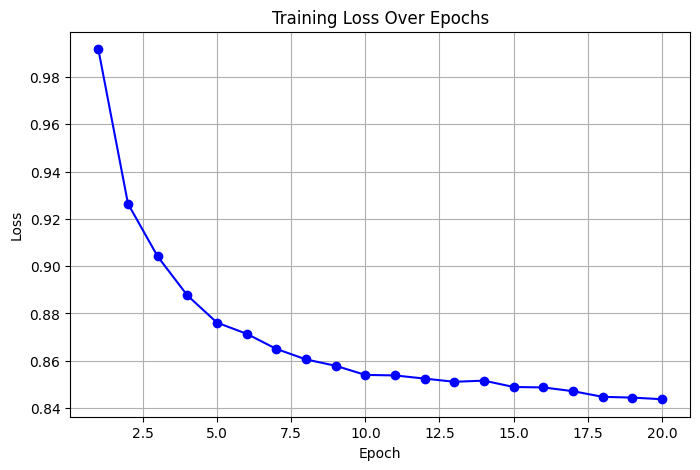

In [41]:
# Plot training loss
plt.figure(figsize = (8,5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker = 'o', color = 'b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

**Observations**

* The loss steadily decreases over 20 epochs, indicating that the model is learning effectively.
* After around epoch 15, the loss starts to plateau, suggesting that additional epochs may yield diminishing returns.
* This plot gives us confidence that the training process is stable and that the model is ready for evaluation on unseen test data.

**Evaluating the Neural Network**

After training, we evaluate the neural network on the test set, which the model has never seen before.

Evaluation helps us understand:
* How well the model generalises to unseen data
* Which classes are predicted accurately and which are confused
* Whether further tuning is needed

We will calculate:
* **Accuracy** overall proportion of correct predictions
* **Classification report** precision, recall, and F1-score for each class
* **Confusion matrix** visual representation of true vs predicted classes

In [42]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    
    all_preds = []   # store all predicted labels
    all_labels = []  # store all true labels
    correct = 0      # count of correct predictions
    total = 0        # total number of examples

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass: compute model outputs
            outputs = model(inputs)
            
            # Choose class with highest predicted score
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update counts for accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Compute and print overall accuracy
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%\n")

    # Classification report for precision, recall, F1-score per class
    print("Classification Report:")
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']
    ))

    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, 
        annot=True,       # show numbers
        fmt='d',          # integer format
        cmap='Blues',
        xticklabels=['CANDIDATE','CONFIRMED','FALSE POSITIVE'],
        yticklabels=['CANDIDATE','CONFIRMED','FALSE POSITIVE']
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Accuracy: 61.33%

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.36      0.02      0.04       437
     CONFIRMED       0.53      0.64      0.58       459
FALSE POSITIVE       0.65      0.87      0.75       945

      accuracy                           0.61      1841
     macro avg       0.51      0.51      0.46      1841
  weighted avg       0.55      0.61      0.54      1841



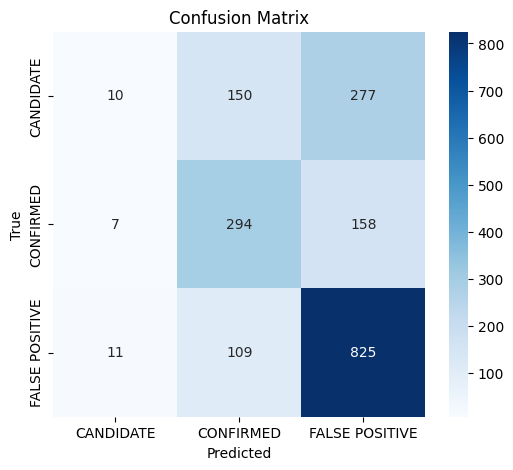

In [43]:
# Evaluate the trained neural network on the test set
evaluate_model(model, test_loader)

## **Comparison and Conclusion**

Before concluding this notebook we'll compare the peformance of the Random Forest (RF) model from Question 1 with the Neural Network (NN) approach explored here. Both models were trained and evaluated on the same dataset using identical features and preprocessing to allow for a fair comparison.

**Accuracy**

The RF reached an overall accuracy of 68.7%, while the NN reached 61.7%. In this case, the RF outperformed the NN in terms of raw accuracy. This result is important as it highlights that more complex models don't guarantee better peformance, particularly when working with limited data or imbalanced classes.

**Performance**

Looking beyond accuracy, the classification reports reveal more subtle differences between the two models.

**Random Forest**
* Performs relatively well across all three classes.
* Achieves strong recalled for `FALSE POSITIVE` (86%) and `CONFIRMED` (77%).
* Struggles with `CANDIDATE` recall (23%), indicating difficulty when identifying this minority class.

**Neural Network**
* Achieves very high recall for `FALSE POSITIVE` (88%), similar to the Random Forest.
* Maintains reasonable peformance on `CONFIRMED` candidates.
* Peforms very poorly on the `CANDIDATE` class, with a recall of just 2% meaning most candidate planets are misclassified.

This suggest that the NN is strongly biased towards majority classes and fails to generalise well to underrepresented classes.

**Precision, Recall, and F1-score**
* **Precision** the Random Forest mains more balanced precision across all classes. The Neural Network's precision for `CANDIDATE` is low reflecting its tendency to rarely predict this class.
* **Recall** the Random Forest shows higher recall for minority classes compared to the Neural Network. This is particularly important in astronomical applications, where missing true candidates can be costly.
* **F1-score** the Random Forest achieves higher F1-scores across all classes indicating a better balance between precision and recall. The Neural Network's F1 for the `CANDIDATE` class is extremely low, reinforcing the idea that it struggles significantly with class imbalance.

Overall, the Random Forest proves to be the more effective model for this task. It achieves higher accuracy, better-balanced class performance, and stronger results on minority classes. The Neural Network, while more flexible, appears to require more data, better handling of class imbalance, and further tuning of its architecture. This comparison demonstrates that for structured tabular data with limited size and class imbalance, tree-based models can outperform neural networks, despite the latter's greater theoretical power.
